In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer

# Load the dataset
file_path = "C:/Users/santh/Downloads/hypothyroid_1.csv"
data = pd.read_csv(file_path)

# Replace '?' with NaN
data.replace('?', np.nan, inplace=True)

# Identify numerical and categorical columns
numerical_cols = ['age', 'tsh', 't3', 'tt4', 't4u', 'fti']  # Assuming these are the numerical columns

# Convert numerical columns to numeric type
for col in numerical_cols:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Impute missing values in numerical columns using KNN
imputer = KNNImputer(n_neighbors=5)
numerical_data_imputed = pd.DataFrame(imputer.fit_transform(data[numerical_cols]), columns=numerical_cols)

# List of columns to convert 'f'/'t' to 0/1
binary_cols = [
    'on_thyroxine', 'query_on_thyroxine', 'on_antithyroid_medication', 'sick', 'pregnant',
    'thyroid_surgery', 'i131_treatment', 'query_hypothyroid', 'query_hyperthyroid', 'lithium',
    'goitre', 'tumor', 'hypopituitary', 'psych', 'tsh_measured', 't3_measured', 'tt4_measured',
    't4u_measured', 'fti_measured', 'tbg_measured'
]

# Impute missing values in categorical columns with the mode
def impute_mode(series):
    mode = series.mode()
    if mode.empty:
        return series
    return series.fillna(mode[0])

for col in binary_cols:
    data[col] = impute_mode(data[col])
    data[col] = data[col].replace({'f': 0, 't': 1})

# Handle the 'sex' column
data['sex'] = impute_mode(data['sex'])
data['sex'] = data['sex'].replace({'F': 0, 'M': 1})

# Convert 'binaryclass' column to 0 and 1
data['binaryclass'] = data['binaryclass'].replace({'P': 1, 'N': 0})

# Combine imputed numerical and categorical data
categorical_cols = [col for col in data.columns if col not in numerical_cols]
categorical_data_imputed = data[categorical_cols]
data_imputed = pd.concat([numerical_data_imputed, categorical_data_imputed], axis=1)

# Save the cleaned data
cleaned_file_path = "C:/Users/santh/Downloads/knn_trained1.csv"
data_imputed.to_csv(cleaned_file_path, index=False)

cleaned_file_path


'C:/Users/santh/Downloads/knn_trained1.csv'

C:\Users\santh\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [26] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\santh\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


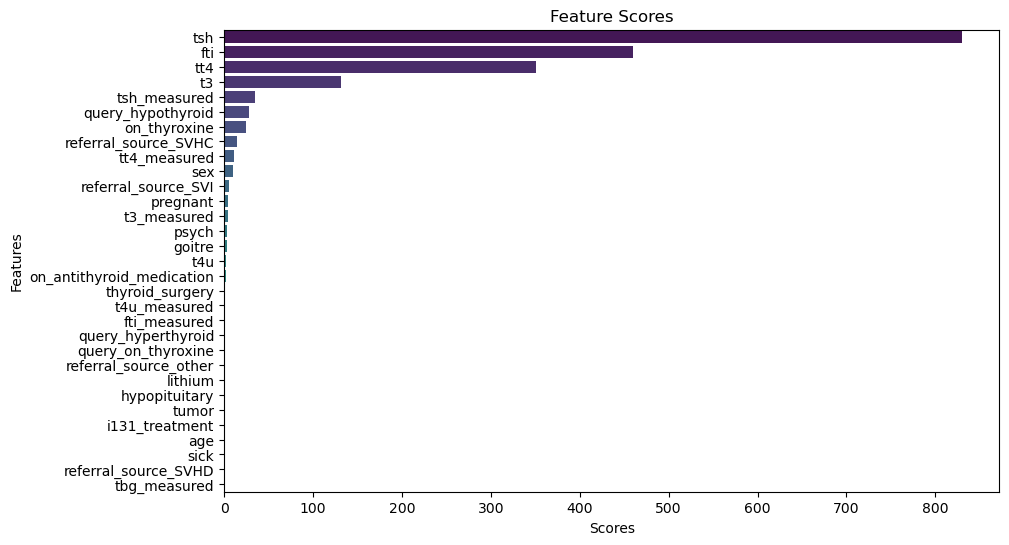

Reduced features: Index(['tsh', 't3', 'tt4', 't4u', 'fti', 'sex', 'on_thyroxine',
       'query_on_thyroxine', 'on_antithyroid_medication', 'pregnant',
       'thyroid_surgery', 'query_hypothyroid', 'query_hyperthyroid', 'lithium',
       'goitre', 'tumor', 'hypopituitary', 'psych', 'tsh_measured',
       't3_measured', 'tt4_measured', 't4u_measured', 'fti_measured',
       'referral_source_SVHC', 'referral_source_SVI', 'referral_source_other'],
      dtype='object')


,tsh,t3,tt4,t4u,fti,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,pregnant,...,psych,tsh_measured,t3_measured,tt4_measured,t4u_measured,fti_measured,referral_source_SVHC,referral_source_SVI,referral_source_other,binaryclass
0,1.30,2.50,125.0,1.140,109.0,0,0,0,0,0,...,0,1,1,1,1,1,1,0,0,1
1,4.10,2.00,102.0,1.014,102.2,0,0,0,0,0,...,0,1,1,1,0,0,0,0,1,1
2,0.98,1.62,109.0,0.910,120.0,1,0,0,0,0,...,0,1,0,1,1,1,0,0,1,1
3,0.16,1.90,175.0,0.988,163.0,0,1,0,0,0,...,0,1,1,1,0,0,0,0,1,1
4,0.72,1.20,61.0,0.870,70.0,0,0,0,0,0,...,0,1,1,1,1,1,0,1,0,1


In [2]:
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = pd.read_csv("C:/Users/santh/Downloads/knn_trained.csv")

# Drop columns with any NaN values
data = data.dropna(axis=1)

# Separate features and target variable
X = data.drop('binaryclass', axis=1)
y = data['binaryclass']

# One-hot encode categorical variables (like 'sex' and 'referral_source')
X = pd.get_dummies(X, drop_first=True)

# Feature selection using SelectKBest
selector = SelectKBest(f_classif, k='all')  # k='all' to get scores for all features
X_selected = selector.fit_transform(X, y)

# Get selected feature names and their scores
selected_features = X.columns[selector.get_support()]
feature_scores = selector.scores_[selector.get_support()]

# Create a DataFrame to store the feature names and their scores
feature_scores_data_set = pd.DataFrame({'Features': selected_features, 'Scores': feature_scores})

# Sort the DataFrame by score in descending order
feature_scores_data_set = feature_scores_data_set.sort_values(by='Scores', ascending=False)

# Plot the feature scores
plt.figure(figsize=(10, 6))
sns.barplot(x='Scores', y='Features', data=feature_scores_data_set, palette='viridis')
plt.title('Feature Scores')
plt.xlabel('Scores')
plt.ylabel('Features')
plt.show()

# Identify and remove the least important features
# For this example, let's remove the bottom 5 features
least_important_features = feature_scores_data_set.tail(5)['Features'].tolist()
X_reduced = X.drop(columns=least_important_features)

# Display the columns of X_reduced
reduced_features = X_reduced.columns
print("Reduced features:", reduced_features)

# Combine reduced features with the target variable
data_reduced = pd.concat([X_reduced, y], axis=1)

# Display the reduced dataset
data_reduced.head()


C:\Users\santh\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [26] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\santh\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


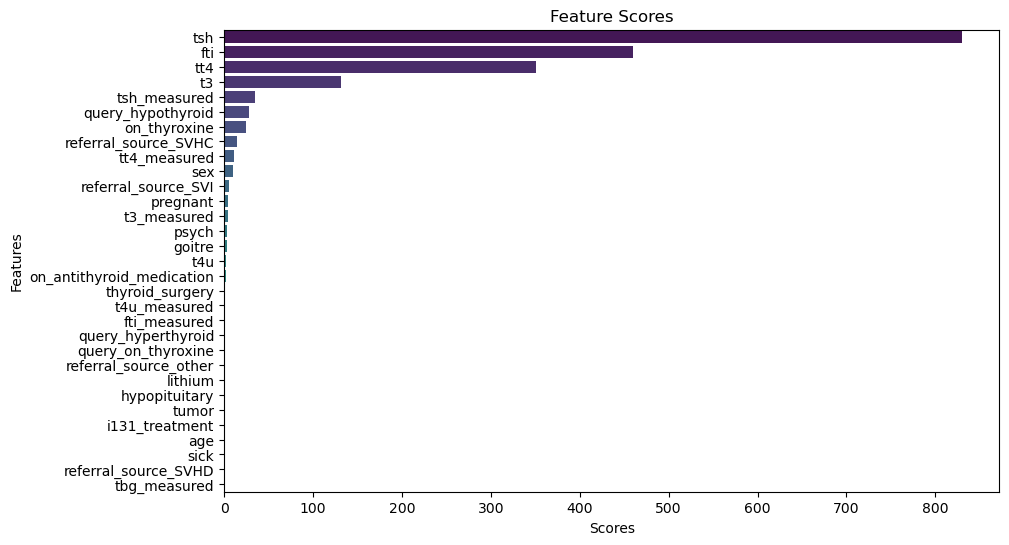

Reduced features: Index(['tsh', 't3', 'tt4', 't4u', 'fti', 'sex', 'on_thyroxine',
       'query_on_thyroxine', 'on_antithyroid_medication', 'pregnant',
       'thyroid_surgery', 'query_hypothyroid', 'query_hyperthyroid', 'lithium',
       'goitre', 'tumor', 'hypopituitary', 'psych', 'tsh_measured',
       't3_measured', 'tt4_measured', 't4u_measured', 'fti_measured',
       'referral_source_SVHC', 'referral_source_SVI', 'referral_source_other'],
      dtype='object')
Accuracy: 0.9960
              precision    recall  f1-score   support

           0       0.98      0.97      0.97        58
           1       1.00      1.00      1.00       697

    accuracy                           1.00       755
   macro avg       0.99      0.98      0.99       755
weighted avg       1.00      1.00      1.00       755



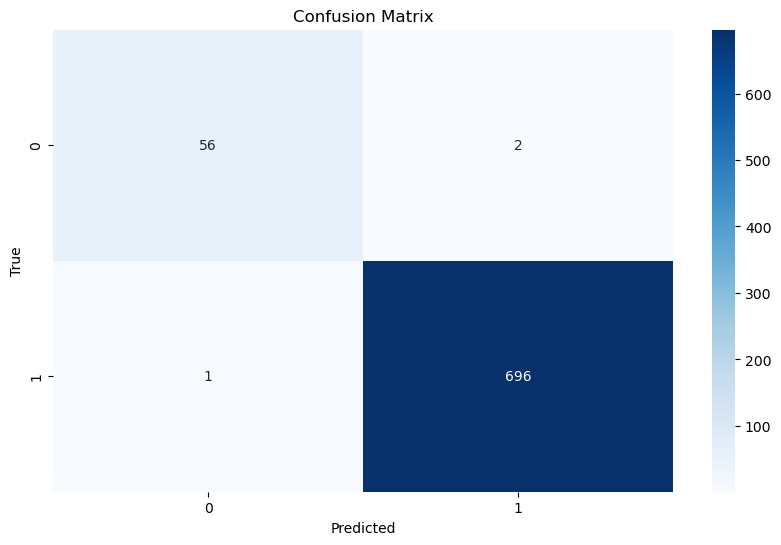

Cross-Validation Accuracy: 0.9944 ± 0.0021
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best Model Accuracy: 0.9947
              precision    recall  f1-score   support

           0       0.98      0.95      0.96        58
           1       1.00      1.00      1.00       697

    accuracy                           0.99       755
   macro avg       0.99      0.97      0.98       755
weighted avg       0.99      0.99      0.99       755



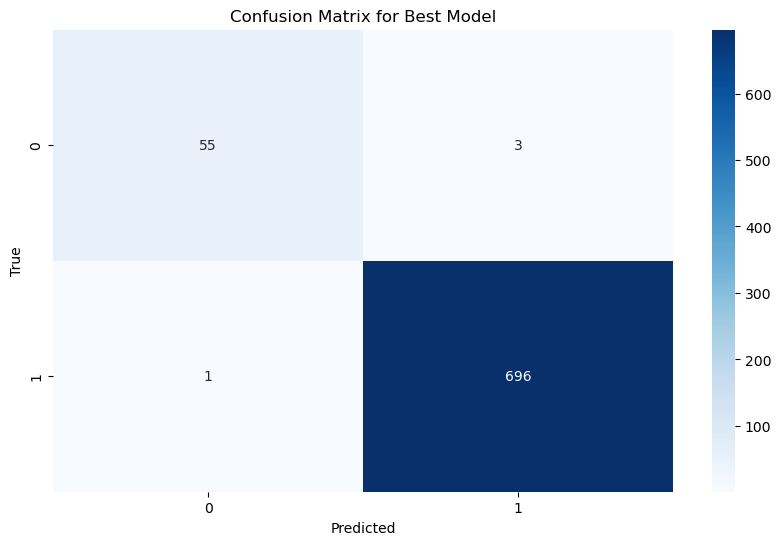

In [1]:
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = pd.read_csv("C:/Users/santh/Downloads/knn_trained.csv")

# Drop columns with any NaN values
data = data.dropna(axis=1)

# Separate features and target variable
X = data.drop('binaryclass', axis=1)
y = data['binaryclass']

# One-hot encode categorical variables (like 'sex' and 'referral_source')
X = pd.get_dummies(X, drop_first=True)

# Feature selection using SelectKBest
selector = SelectKBest(f_classif, k='all')  # k='all' to get scores for all features
X_selected = selector.fit_transform(X, y)

# Get selected feature names and their scores
selected_features = X.columns[selector.get_support()]
feature_scores = selector.scores_[selector.get_support()]

# Create a DataFrame to store the feature names and their scores
feature_scores_data_set = pd.DataFrame({'Features': selected_features, 'Scores': feature_scores})

# Sort the DataFrame by score in descending order
feature_scores_data_set = feature_scores_data_set.sort_values(by='Scores', ascending=False)

# Plot the feature scores
plt.figure(figsize=(10, 6))
sns.barplot(x='Scores', y='Features', data=feature_scores_data_set, palette='viridis')
plt.title('Feature Scores')
plt.xlabel('Scores')
plt.ylabel('Features')
plt.show()

# Identify and remove the least important features
# For this example, let's remove the bottom 5 features
least_important_features = feature_scores_data_set.tail(5)['Features'].tolist()
X_reduced = X.drop(columns=least_important_features)
# Display the columns of X_reduced
reduced_features = X_reduced.columns
print("Reduced features:", reduced_features)


# Combine reduced features with the target variable
data_reduced = pd.concat([X_reduced, y], axis=1)


# Display the reduced dataset
data_reduced.head()
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# Train a Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Print classification report
print(classification_report(y_test, y_pred))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Perform cross-validation
cv_scores = cross_val_score(rf_model, X_reduced, y, cv=5)
print(f'Cross-Validation Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}')

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best parameters from GridSearchCV
print(f'Best Parameters: {grid_search.best_params_}')

# Predict on the test set with the best model
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

# Evaluate the best model
best_accuracy = accuracy_score(y_test, y_pred_best)
print(f'Best Model Accuracy: {best_accuracy:.4f}')
print(classification_report(y_test, y_pred_best))

# Plot confusion matrix for the best model
conf_matrix_best = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix_best, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Best Model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [2]:
import pickle

# Assuming you have a trained model named 'best_model'
model_path = 'model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(best_model, f)


In [3]:
from flask import Flask, render_template, request, jsonify
import pickle
import numpy as np
import threading
import webbrowser
import time

# Load the trained model
with open('model.pkl', 'rb') as file:
    model = pickle.load(file)

app = Flask(__name__)

@app.route('/')
def home():
    return render_template('index.html')

@app.route('/predict', methods=['POST'])
def predict():
    # Collect form data
    form_data = request.form
    features = [
        float(form_data['tsh']),
        float(form_data['t3']),
        float(form_data['tt4']),
        float(form_data['t4u']),
        float(form_data['fti'])
    ]
    
    # Collect binary features
    binary_features = [
        form_data.get('sex'),
        form_data.get('on_thyroxine'),
        form_data.get('query_on_thyroxine'),
        form_data.get('on_antithyroid_medication'),
        form_data.get('pregnant'),
        form_data.get('thyroid_surgery'),
        form_data.get('query_hypothyroid'),
        form_data.get('query_hyperthyroid'),
        form_data.get('lithium'),
        form_data.get('goitre'),
        form_data.get('tumor'),
        form_data.get('hypopituitary'),
        form_data.get('psych'),
        form_data.get('tsh_measured'),
        form_data.get('t3_measured'),
        form_data.get('tt4_measured'),
        form_data.get('t4u_measured'),
        form_data.get('fti_measured'),
        form_data.get('referral_source_SVHC'),
        form_data.get('referral_source_SVI'),
        form_data.get('referral_source_other')
    ]
    
    # Convert binary features to 1 or 0
    binary_values = [1 if value else 0 for value in binary_features]
    input_features = features + binary_values
    
    # Convert input to numpy array
    input_array = np.array([input_features])
    
    # Make prediction
    prediction = model.predict(input_array)[0]
    
    # Map prediction to positive/negative
    prediction_label = 'Positive' if prediction == 1 else 'Negative'
    
    return jsonify({'prediction': prediction_label})

def open_browser():
    time.sleep(1)
    webbrowser.open("http://127.0.0.1:5000/")

if __name__ == '__main__':
    threading.Thread(target=open_browser).start()
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with watchdog (windowsapi)


SystemExit: 1

C:\Users\santh\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3513: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
from flask import Flask, render_template, request, jsonify
import numpy as np
import pickle

app = Flask(__name__)

# Load the trained model
with open('model.pkl', 'rb') as file:
    model = pickle.load(file)

@app.route('/')
def index():
    return render_template('index.html')

@app.route('/predict', methods=['POST'])
def predict():
    # Extract form data
    data = request.form.to_dict()
    
    # Extract numeric features
    tsh = float(data.get('tsh', 0))
    t3 = float(data.get('t3', 0))
    tt4 = float(data.get('tt4', 0))
    t4u = float(data.get('t4u', 0))
    fti = float(data.get('fti', 0))
    
    # Extract binary features
    sex = data.get('sex', 'male')  # Default to 'male' if not provided
    on_thyroxine = 1 if data.get('on_thyroxine') == 'yes' else 0
    query_on_thyroxine = 1 if data.get('query_on_thyroxine') == 'yes' else 0
    on_antithyroid_medication = 1 if data.get('on_antithyroid_medication') == 'yes' else 0
    pregnant = 1 if data.get('pregnant') == 'yes' else 0
    thyroid_surgery = 1 if data.get('thyroid_surgery') == 'yes' else 0
    query_hypothyroid = 1 if data.get('query_hypothyroid') == 'yes' else 0
    query_hyperthyroid = 1 if data.get('query_hyperthyroid') == 'yes' else 0
    lithium = 1 if data.get('lithium') == 'yes' else 0
    goitre = 1 if data.get('goitre') == 'yes' else 0
    tumor = 1 if data.get('tumor') == 'yes' else 0
    hypopituitary = 1 if data.get('hypopituitary') == 'yes' else 0
    psych = 1 if data.get('psych') == 'yes' else 0
    tsh_measured = 1 if data.get('tsh_measured') == 'yes' else 0
    t3_measured = 1 if data.get('t3_measured') == 'yes' else 0
    tt4_measured = 1 if data.get('tt4_measured') == 'yes' else 0
    t4u_measured = 1 if data.get('t4u_measured') == 'yes' else 0
    fti_measured = 1 if data.get('fti_measured') == 'yes' else 0
    referral_source_SVHC = 1 if data.get('referral_source_SVHC') == 'yes' else 0
    referral_source_SVI = 1 if data.get('referral_source_SVI') == 'yes' else 0
    referral_source_other = 1 if data.get('referral_source_other') == 'yes' else 0

    # Convert to model input format
    input_data = np.array([[1 if sex == 'male' else 0, tsh, t3, tt4, t4u, fti,
                            on_thyroxine, query_on_thyroxine, on_antithyroid_medication, pregnant,
                            thyroid_surgery, query_hypothyroid, query_hyperthyroid,
                            lithium, goitre, tumor, hypopituitary, psych,
                            tsh_measured, t3_measured, tt4_measured, t4u_measured,
                            fti_measured, referral_source_SVHC, referral_source_SVI,
                            referral_source_other]])

    # Predict
    prediction = model.predict(input_data)[0]
    result = 'Positive' if prediction == 1 else 'Negative'

    return jsonify({'prediction': result})

if __name__ == '__main__':
    app.run(port=8000)


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:8000
Press CTRL+C to quit
127.0.0.1 - - [09/Jul/2024 20:03:32] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [09/Jul/2024 20:03:32] "GET /static/styles.css HTTP/1.1" 200 -
127.0.0.1 - - [09/Jul/2024 20:03:32] "GET /favicon.ico HTTP/1.1" 404 -
C:\Users\santh\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
127.0.0.1 - - [09/Jul/2024 20:07:10] "POST /predict HTTP/1.1" 200 -
